In [48]:
#run this to install the package
!pip install -r requirements.txt

In [49]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

## **From Sheet to DataFrame to Regression Object**

In [50]:
US_Data = "1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU"

In [51]:
x = read_sheets(US_Data,sheet='Food Expenditures 2021')
x["j"] = x["food_name"]
x = x.set_index(['i','t','m','j'])["grams"].squeeze()

# Household characteristics
d = read_sheets(US_Data,sheet="Household Characteristics 2021")
d.columns.name = 'k'
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})
d['log_household'] = np.log(d['HH_size'])
d.drop("HH_size", axis= 1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)
d.set_index(['i','t','m'],inplace=True)

### Filter Data Down

In [52]:
# Step 1: Filter goods by frequency (top 400)
food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(350).index

# Filter x and y to only include these popular goods.
x_filtered = x[x.index.get_level_values('j').isin(top_foods)]
y_filtered = y[y.index.get_level_values('j').isin(top_foods)]

# Step 2: Instead of random sampling, use all households present in y_filtered.
# Get all unique household ids from y_filtered.
common_ids = y_filtered.index.get_level_values('i').unique()

# Filter y and d to keep only households in common_ids.
# (This is effectively taking the full data that has corresponding expenditures.)
y_final = y_filtered[y_filtered.index.get_level_values('i').isin(common_ids)]
d_final = d[d.index.get_level_values('i').isin(common_ids)]

# Filter y and d to match
# sample_ids = y_filtered.index.get_level_values('i').unique().to_series().sample(1750, random_state=42)
# y_sample = y_filtered[y_filtered.index.get_level_values('i').isin(sample_ids)]
# d_sample = d[d.index.get_level_values('i').isin(sample_ids)]

# Final checks
print("Shape of y_final:", y_final.shape)
print("Shape of d_final:", d_final.shape)

Shape of y_final: (85881,)
Shape of d_final: (6711, 3)


In [53]:
y_final

i       t     m    j                                                        
130378  2021  USA  Caesar dressing                                              1.589235
                   Cheese, parmesan, dry grated                                 0.732368
                   Chicken, ns as to part and cooking method, skin not eaten    5.136386
                   Coffee, brewed                                               6.396930
                   Coffee, instant, reconstituted                               5.703782
                                                                                  ...   
142310  2021  USA  Mayonnaise, regular                                          2.639057
                   Potato chips, plain                                          2.995732
                   Sugar substitute, sucralose, powder                          0.000000
                   Water, bottled, plain                                        6.201523
                   Wine, red     

## **Build Price Data**

In [54]:
#Add price data
p = pd.read_csv("proj3_min_cost_data - prices.csv")

# Change column names to actual unit values
p["u"] = "Kg"

p["m"] = "USA"

# Adjust price to per Kg from per g
p["price"] = p["price"] * 10

# Filter for only 2017/2018 prices
p = p[p["t"] == "2017/2018"]

# Change price data from 2017/2018 to 2021 using avg US CPIs in 2017/2018 and 2021
cpi_2021 = 271.0
cpi_2018 = 250.0
p["price"] = p["price"] * (cpi_2021/cpi_2018)

p["t"] = "2021"


codes = pd.read_csv("proj3_min_cost_data - recipes.csv")

codes = codes[["parent_foodcode", "parent_desc"]]
c = codes.groupby("parent_foodcode").first()
c.rename(columns = {"parent_foodcode": "j"})
p = p.join(c, on="j")
p_with_j = p # use later on for nutrition data
p = p.drop("j", axis=1)
p = p.rename(columns = {"parent_desc":"j"})

# Now prices
p = p.set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')
# Identify the common keys between x_filtered.index.levels[-1] and p.columns
common_keys = p.columns.intersection(x_filtered.index.levels[-1])

# Now subset p with these keys and transpose the result.
p = p[common_keys].T

## **Run Regression**

In [55]:
from cfe import Regression

# Run the regression
result = Regression(y=y_final, d=d_final, compute_se=False, rectify=False, 
                    min_obs=10, min_prop_items=0.002)

In [56]:
predicted = result.predicted_expenditures()
predicted.head()

i       t     m    j               
130378  2021  USA  Apple, raw          168.376125
                   Avocado, raw         63.690791
                   Banana, raw         122.454705
                   Blueberries, raw     56.337073
                   Butter, stick        10.290546
dtype: float64

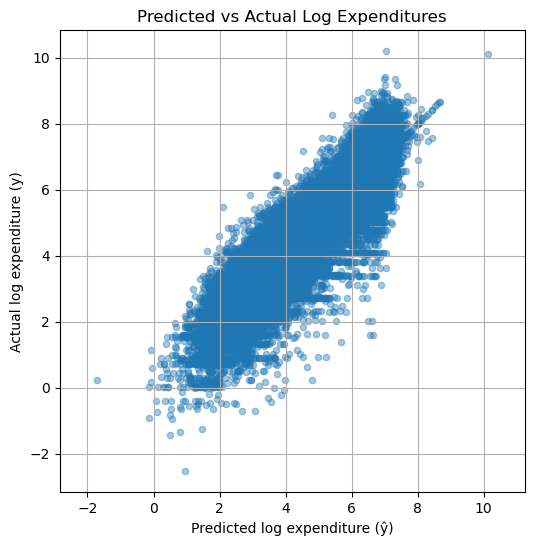

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create DataFrame of actual vs predicted log expenditures
df = pd.DataFrame({
    'y': y_final,
    'yhat': result.get_predicted_log_expenditures()
})

# Drop missing values (some may not match if data was trimmed)
df = df.dropna()

# Plot
df.plot.scatter(x='yhat', y='y', alpha=0.4, figsize=(6, 6))
plt.title("Predicted vs Actual Log Expenditures")
plt.xlabel("Predicted log expenditure (ŷ)")
plt.ylabel("Actual log expenditure (y)")
plt.grid(True)
plt.axis("equal")  # force square axes
plt.show()

In [ ]:
ax = result.graph_beta()

Can't compute covariance matrix; too few Hot pepper sauce.
Can't compute covariance matrix; too few Pork bacon, ns as to fresh, smoked or cured, cooked.


In [ ]:
result.get_beta().sort_values(ascending=False)

In [ ]:
foods_in_regression = result.beta.index.get_level_values('j').unique()

In [ ]:
result.get_gamma().head()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

gamma = result.get_gamma()
gamma_sorted = gamma.sort_values(by="Constant", ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(data=gamma_sorted, x="Constant", y="j")
plt.xlabel("Gamma (Constant)")
plt.ylabel("Food Item")
plt.title("Gamma Constants by Food Item")
plt.tight_layout()
plt.show()

In [ ]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

In [ ]:
ax = result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)].plot.hist(bins=100,density=True)
result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)].plot.kde(ax=ax)

In [ ]:
gamma = result.get_gamma()
gamma

## Saving Regression

In [ ]:
result.to_pickle('us_estimates_2021.rgsn')

In [ ]:
import cfe

# Load the result back into memory
result = cfe.regression.read_pickle('us_estimates_2021.rgsn')

## **Demand and Utility**

Having estimated the demand system, we can examine the implied demand curves.

## Budgets
Get food budget for all households, then find median budget:

In [ ]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

**Reference Prices**
  
Choose reference prices. Here we’ll choose a particular year, and average prices across markets. If you wanted to focus on particular market you’d do this differently.

In [ ]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)

# Instead of directly indexing with result.beta.index (which fails for missing keys),
# reindex pbar to have the same index as result.beta and fill missing prices with 1.
pbar = pbar.reindex(result.beta.index, fill_value=1)

# (Optional) Get the common keys, which should be all keys in result.beta.index:
common_keys = pbar.index.intersection(result.beta.index)
pbar = pbar.loc[common_keys]

# Replace any remaining missing values with 1.
pbar = pbar.replace(np.nan, 1)

# Finally, define a function to change the price of a single good in the price vector.
def my_prices(p0, j, p=pbar):
    """
    Change price of the jth good to p0, holding all other prices fixed.
    
    Parameters:
      p0 : float
          New price for the jth good.
      j : label
          Identifier for the good (must be present in p).
      p : pd.Series
          Price vector (default is pbar).
    
    Returns:
      pd.Series : A new price vector with the updated value.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

common_keys

## **Demand Curve for One Food**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline

def plot_demand_curve(good):
    """
    Plot the demand curve for a given good over a range of price scales.
    
    Parameters
    ----------
    good : str
        The common key (food identifier) for which you want the demand curve,
        e.g. "Banana, raw".
        
    Global Variables (should be defined before calling this function):
      pbar         : pd.Series of reference prices (indexed by food identifier)
      result       : an object with a demands() method and attribute beta.index.
      xref         : reference expenditure vector (e.g., median household expenditures)
      xbar         : household total expenditures used to compute quantiles.
      my_prices()  : function that returns a modified price vector.
    """
    # Suppress warnings about negative beta values
    warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
    
    # Reindex pbar so that it has the same index as result.beta.index, filling missing keys with 1.
    pbar_local = pbar.reindex(result.beta.index, fill_value=1)
    
    # Define a range of scale factors: vary prices from 50% to 200% of the reference price.
    scale = np.linspace(0.5, 2, 20)
    
    # Compute demand for the given good at different price levels.
    # Wrap the list comprehensions in a warnings.catch_warnings block to suppress any warnings during computation.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
        median_demand = [result.demands(xref, my_prices(pbar_local[good] * s, good, pbar_local))[good]
                         for s in scale]
        demand_q25 = [result.demands(xbar.quantile(0.25), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                      for s in scale]
        demand_q75 = [result.demands(xbar.quantile(0.75), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                      for s in scale]
    
    # Create the plot.
    plt.figure(figsize=(8, 6))
    plt.plot(median_demand, scale, marker="o", label="Median Budget")
    plt.plot(demand_q25, scale, marker="s", label="25th Percentile Budget")
    plt.plot(demand_q75, scale, marker="^", label="75th Percentile Budget")
    
    # Add axis labels, title, legend, and grid.
    plt.xlabel(f"Quantities of {good} Demanded")
    plt.ylabel(f"Price (relative to base of {pbar_local[good]:.2f})")
    plt.title(f"Demand Curve for {good}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_demand_curve('Banana, raw')

## **Demand Curve for More than One good**

In [ ]:
def plot_demand_curves(goods):
    """
    Plot demand curves for multiple goods over a range of price scales.
    
    Parameters
    ----------
    goods : tuple or list of str
        The food identifiers (common keys) for which you want to plot demand curves.
        For example: ('Banana, raw', 'Apple, raw', 'Milk, whole')
    
    Global variables required:
      - pbar: pd.Series with reference prices (indexed by food identifiers)
      - result: an object with methods demands() and attribute beta.index
      - xref: reference expenditure vector (e.g., median expenditures)
      - xbar: household total expenditures (used for quantile calculations)
      - my_prices(): function to adjust the price vector
    """
    # Suppress specific warnings (from consumerdemands._utils)
    warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
    
    # Ensure pbar covers all keys in result.beta.index; fill missing values with 1.
    pbar_local = pbar.reindex(result.beta.index, fill_value=1)
    
    # Define a range of scale factors to vary the price from 50% to 200% of reference.
    scale = np.linspace(0.5, 2, 20)
    
    # Create a new figure for the plot.
    plt.figure(figsize=(10, 8))
    
    # Loop over each good in the input tuple/list.
    for good in goods:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
            # Compute the demand for the given good at various price levels.
            median_demand = [result.demands(xref, my_prices(pbar_local[good] * s, good, pbar_local))[good]
                             for s in scale]
            demand_q25 = [result.demands(xbar.quantile(0.25), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                          for s in scale]
            demand_q75 = [result.demands(xbar.quantile(0.75), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                          for s in scale]
        
        # Plot each demand curve with distinct line styles and markers.
        plt.plot(median_demand, scale,
                 label=f"{good} (Median Budget)")
        plt.plot(demand_q25, scale,
                 label=f"{good} (25th Percentile Budget)")
        plt.plot(demand_q75, scale,
                 label=f"{good} (75th Percentile Budget)")
    
    # Add labels, title, legend, and grid.
    plt.xlabel("Quantity Demanded")
    # This label uses the base reference price of the first good in the list for display.
    plt.ylabel(f"Price (relative to base of {pbar_local[goods[0]]:.2f})")
    plt.title("Demand Curves for Selected Goods")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Example usage:
plot_demand_curves(('Banana, raw', 'Milk, whole'))

## **Engle Curves**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define scale, say we vary the budget from 50% to 200% of xref
scale = np.linspace(0.5, 2.0, 20)

# Now plot
fig, ax = plt.subplots()
ax.plot(np.log(scale*xref),
        [result.expenditures(s*xref, pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves')
plt.show()

In [ ]:
def plot_engel_curves(interesting_goods, xref, scale, pbar, result):
    """
    Plot Engel curves for a list of specified goods.
    
    Parameters:
      interesting_goods: list of str
          A list of goods (by food name or id) for which to plot the curve.
      xref: float
          The base household budget.
      scale: array-like
          A list or array of scaling factors for the budget (e.g., np.linspace(0.5,2,20)).
      pbar: pandas.Series or DataFrame
          The reference prices for foods. The index should contain the goods' names.
      result:
          An object with a method `expenditures(budget, pbar)` that returns a pandas Series 
          with expenditures for each food (keys corresponding to food names).
    
    Returns:
      fig, ax : matplotlib Figure and Axes objects.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Loop over each requested good and calculate its expenditure share at each budget.
    for good in interesting_goods:
        shares = []
        for s in scale:
            budget = s * xref  # Scale the base budget by s.
            exp_series = result.expenditures(budget, pbar)
            # Check if the good exists in the returned series
            if good in exp_series.index:
                share = exp_series[good] / budget
            else:
                # Print a warning if the good is not found and set the share to NaN.
                print(f"Warning: '{good}' not found in expenditure series at budget {budget:.2f}")
                share = np.nan
            shares.append(share)
            
        # Plot the Engel curve for this good using log(s * xref) on x-axis.
        ax.plot(np.log(scale * xref), shares, label=good)
    
    # Set axis labels and title.
    ax.set_xlabel(f'Log Budget (relative to base of {xref:.0f})', fontsize=12)
    ax.set_ylabel('Expenditure Share', fontsize=12)
    ax.set_title("Engel Curves for Selected Goods", fontsize=14, fontweight='bold')
    ax.legend(fontsize=8, loc='best')
    plt.tight_layout()
    
    return fig, ax

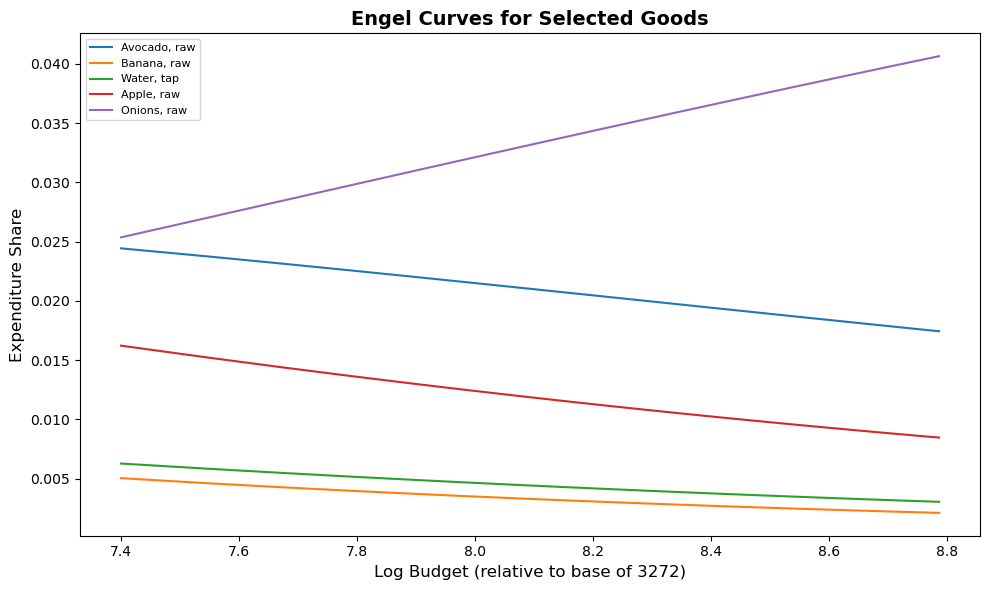

In [29]:
# Example usage:
# Define your variables appropriately
xref = 3272  # example base budget
scale = np.linspace(0.5, 2, 20)  # example scale factors
# pbar and result must be defined elsewhere in your code:
# For example, pbar could be a pandas Series keyed by food names,
# and result should be an object with a method expenditures(budget, pbar).

interesting_goods = ["Avocado, raw", "Banana, raw", "Water, tap", "Apple, raw", "Onions, raw"]

fig, ax = plot_engel_curves(interesting_goods, xref, scale, pbar, result)
plt.show()

## **Indirect Utility**

Text(0.5, 1.0, 'Indirect Utility Function')

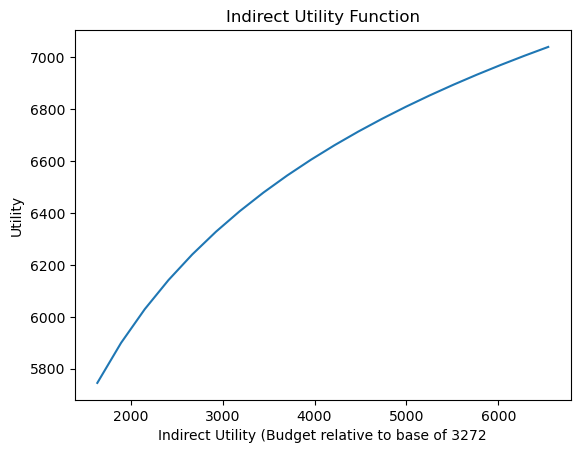

In [30]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

# **[A] Nutritional Data**
### Step 1: Acquire DataFrames

In [31]:
xhat.unstack('j')

,,j,"Apple, raw","Avocado, raw","Banana, raw","Blueberries, raw","Butter, stick","Butter, tub","Cantaloupe, raw","Carrots, raw","Cereal, granola","Cheese, cheddar",...,"Sugar, white, granulated or lump","Tea, hot, leaf, black","Tomatoes, for use on a sandwich","Tomatoes, raw","Tortilla chips, plain","Water, bottled, plain","Water, carbonated, flavored","Water, tap","Watermelon, raw","Wine, red"
i,t,m,,,,,,,,,,,,,,,,,,,,,
130378,2021,USA,169.201910,NaN,121.724431,56.183349,10.345153,NaN,NaN,41.753302,NaN,36.068849,...,13.746664,NaN,24.450509,60.305575,36.289535,1108.755574,NaN,1036.710260,NaN,NaN
130379,2021,USA,309.328178,NaN,179.430899,130.649737,22.383525,NaN,NaN,88.925797,NaN,83.409444,...,22.537902,NaN,37.622003,147.610251,81.105741,1824.079772,NaN,1926.209568,NaN,NaN
130380,2021,USA,134.060142,NaN,99.294970,40.482529,7.585567,NaN,NaN,28.115586,NaN,26.420559,...,9.274143,NaN,18.393372,44.413560,22.287578,920.160853,NaN,873.090185,NaN,NaN
130381,2021,USA,142.927363,NaN,99.894005,51.093817,7.310612,NaN,NaN,52.743842,NaN,33.534423,...,13.173057,NaN,20.964429,47.938049,31.516412,891.418068,NaN,1103.432382,NaN,NaN
130382,2021,USA,160.993585,NaN,118.956494,56.208659,8.645141,NaN,NaN,59.163298,NaN,39.869706,...,16.968738,NaN,25.743829,52.134247,39.052492,945.573398,NaN,1011.201633,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142303,2021,USA,96.634222,NaN,74.564750,26.568724,5.609934,NaN,NaN,14.926065,NaN,13.624845,...,5.849768,NaN,13.248823,31.916852,14.939348,836.189400,NaN,751.853906,NaN,NaN
142304,2021,USA,169.984151,NaN,124.245437,58.591168,9.535091,NaN,NaN,55.511587,NaN,41.488176,...,16.515727,NaN,26.223207,56.756089,39.428139,1009.070662,NaN,1026.559966,NaN,NaN
142307,2021,USA,226.053484,NaN,141.030870,84.842828,14.145831,NaN,NaN,61.487272,NaN,58.697603,...,15.534805,NaN,27.667095,92.453245,45.829150,1339.738541,NaN,1454.775231,NaN,NaN


In [32]:
p

t,2021
m,USA
j,
Agave liquid sweetener,9.241013
"Alcoholic malt beverage, sweetened",4.083005
"Alfalfa sprouts, raw",17.574317
Alfredo sauce,5.459241
Almond butter,19.146529
...,...
"Yogurt, nonfat milk, plain",4.468226
"Yogurt, soy",9.966253


In [33]:
p_new = pd.read_csv("proj3_min_cost_data - prices.csv")
p_new["u"] = "Kg"

p_new["m"] = "USA"

p_new["price"] = p_new["price"] * 10

p_new = p_new[p_new["t"] == "2017/2018"]


# Change price data from 2017/2018 to 2021 using avg US CPIs in 2017/2018 and 2021
cpi_2021 = 271.0
cpi_2018 = 250.0
p_new["price"] = p_new["price"] * (cpi_2021/cpi_2018)

p_new["t"] = "2021"

p_new = p_new.join(c, on="j") 
p_new = p_new.drop("j", axis=1)
p_new = p_new.drop("t", axis=1)
p_new = p_new.drop("u", axis=1)
p_new = p_new.rename(columns = {"parent_desc":"j"})

p_new

,m,price,j
10577,USA,1.089247,"Milk, NFS"
10578,USA,1.065355,"Milk, whole"
10579,USA,0.998201,"Milk, reduced fat (2%)"
10580,USA,0.985508,"Milk, low fat (1%)"
10581,USA,1.002060,"Milk, fat free (skim)"
...,...,...,...
15007,USA,1.311185,Sports drink (Gatorade G)
15008,USA,0.996651,Sports drink (Powerade)
15009,USA,1.236671,"Sports drink, low calorie (Gatorade G2)"
15010,USA,0.964782,"Sports drink, low calorie (Powerade Zero)"


In [34]:
p_pivot = p_new.pivot_table(
    index=["m"],   # or ["m", "t"] if you prefer that order
    columns="j",
    values="price",
    aggfunc="sum"      # or another aggregation if you have duplicates
)

p_pivot

j,100 GRAND Bar,3 MUSKETEERS Bar,"Adobo, with noodles","Adobo, with rice",Agave liquid sweetener,"Alcoholic malt beverage, sweetened","Alfalfa sprouts, raw",Alfredo sauce,Almond butter,"Almond milk, sweetened",...,"Yogurt, low fat milk, plain","Yogurt, nonfat milk, flavors other than fruit","Yogurt, nonfat milk, fruit","Yogurt, nonfat milk, plain","Yogurt, soy","Yogurt, whole milk, baby food","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain","Zucchini soup, cream of, prepared with milk"
m,,,,,,,,,,,,,,,,,,,,,
USA,11.070784,13.636395,7.314843,6.921687,9.241013,4.083005,17.574317,5.459241,19.146529,1.840014,...,4.468226,5.731379,4.718012,4.468226,9.966253,6.452141,5.731379,4.718012,4.468226,2.652385


In [35]:
# Expenditures divided by prices/kg gives quantities in kgs...
xhat_unstacked = xhat.unstack('j')
xhat_unstacked_aligned = xhat_unstacked.reindex(index=p_pivot.index, columns=p_pivot.columns)
common_columns = xhat_unstacked_aligned.columns.intersection(p_pivot.columns)
common_index = xhat_unstacked_aligned.index.intersection(p_pivot.index)

p_pivot_aligned = p_pivot.loc[common_index, common_columns]

qhat = (xhat_unstacked/p_pivot_aligned).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [36]:
nutrients = pd.read_csv("proj3_min_cost_data - nutrients.csv")
recipes = pd.read_csv("proj3_min_cost_data - recipes.csv")

# from fndds diet problem: normalize weights to percentage terms. 
recipes['ingred_wt'] = recipes['ingred_wt']/recipes.groupby(['parent_foodcode'])['ingred_wt'].transform("sum")

# we're going to extend the recipes data frame to include the nutrient profiles of its ingredients (in 100g)
df = recipes.merge(nutrients, how="left", on="ingred_code")

# multiply all nutrients per 100g of an ingredient by the weight of that ingredient in a recipe.
numeric_cols = list(df.select_dtypes(include=["number"]).columns)
numeric_cols.remove("ingred_wt")
df[numeric_cols] = df[numeric_cols].mul(df["ingred_wt"], axis=0)
df = df.rename(columns={'parent_desc': 'j'})

# sum nutrients of food codes (over the multiple ingredients)
# python tip: one can merge dictionaries dict1 dict2 using **, that is: dict_merge = {**dict1, **dict2}. 
#The ** effectively "unpacks" the key value pairs in each dictionary
df = df.groupby('j').agg({**{col: "sum" for col in numeric_cols},
                                        "j": "first"})
df.drop("parent_foodcode", axis = 1, inplace=True)
df.drop("ingred_code", axis = 1, inplace=True)
df.drop("j", axis = 1, inplace=True)

df.index.name = "j"

fct = df

In [37]:
fct.index

Index(['100 GRAND Bar', '3 MUSKETEERS Bar', '3 Musketeers Truffle Crisp Bar',
       'Abalone, cooked, NS as to cooking method',
       'Abalone, floured or breaded, fried', 'Abalone, steamed or poached',
       'Adobo, with noodles', 'Adobo, with rice', 'Agave liquid sweetener',
       'Air filled fritter or fried puff, without syrup, Puerto Rican style',
       ...
       'Yogurt, whole milk, plain', 'Yokan', 'Youngberries, raw', 'Yuca fries',
       'Zabaglione', 'Zombie', 'Zucchini lasagna, diet frozen meal',
       'Zucchini soup, cream of, prepared with milk', 'Zucchini, pickled',
       'Zwieback toast'],
      dtype='object', name='j', length=8886)

In [38]:
qhat.columns

Index(['Apple, raw', 'Banana, raw', 'Blueberries, raw', 'Butter, stick',
       'Carrots, raw', 'Coffee creamer, liquid, flavored', 'Coffee, brewed',
       'Cucumber, raw', 'Grapes, raw',
       'Italian dressing, made with vinegar and oil', 'Ketchup',
       'Lettuce, for use on a sandwich', 'Lettuce, raw', 'Mayonnaise, regular',
       'Milk, reduced fat (2%)', 'Milk, whole', 'Mustard', 'Onions, raw',
       'Soft drink, cola, diet', 'Sour cream, regular', 'Strawberries, raw',
       'Sugar, white, granulated or lump', 'Tomatoes, for use on a sandwich',
       'Tomatoes, raw', 'Tortilla chips, plain', 'Water, tap'],
      dtype='object', name='j')

## **Map predicted quantities into nutrients**

In [39]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

Capric acid             54.474372
Lauric acid             56.859648
Myristic acid          198.829192
Palmitic acid          757.058281
Palmitoleic acid        21.199756
                        ...      
Vitamin E              263.841852
Vitamin E, added         0.000000
Vitamin K             5833.620881
Water               619015.929501
Zinc                   560.522705
Length: 65, dtype: float64

In [40]:
rdi = pd.read_csv("proj3_min_cost_data - rda_new.csv")
rdi["n"] = rdi["Nutrient"]
rdi.drop("Nutrient", axis = 1, inplace=True)
rdi.drop("Nutrient Type", axis = 1, inplace=True)
rdi.drop("Unit", axis = 1, inplace=True)
rdi.drop("Constraint Type", axis = 1, inplace=True)
rdi = rdi.set_index("n")

In [41]:
d = read_sheets(US_Data,sheet="Household Characteristics 2021")
d.columns.name = 'k'
d = d.replace(np.nan,0)

In [42]:
# Define age bins and labels
bins = [0, 4, 9, 14, 19, 31, 51, 100]
labels = ['00-03', '04-08', '09-13', '14-18', '19-30', '31-50', '51-99']

# Assign age group based on bins
d['age_group'] = pd.cut(d['age'], bins=bins, labels=labels, right=False)

# Create column name like "Females 00-03", "Males 14-18", etc.
d['group'] = d['sex'] + 's ' + d['age_group'].astype(str)

# Count each person as 1
d['count'] = 1

# Pivot the table to wide format: rows = (i, t, m), columns = group
df_grouped = d.pivot_table(index=['i', 't', 'm'], columns='group', values='count',  aggfunc='sum', fill_value=0)

# Flatten the column index
df_grouped.columns.name = None
df_grouped = df_grouped.reset_index()

# Add log household size
df_hsize = d.drop_duplicates(['i', 't', 'm'])[['i', 't', 'm', 'HH_size']]
df_hsize['log HSize'] = np.log(df_hsize['HH_size'])

# Merge back
final_d = pd.merge(df_grouped, df_hsize.drop(columns='HH_size'), on=['i', 't', 'm'])

final_d.set_index(['i','t','m'],inplace=True)
final_d.head()

,,,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,
130378,2021,USA,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.386294
130379,2021,USA,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.693147
130380,2021,USA,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.945910
130381,2021,USA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.693147
130382,2021,USA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.386294


In [43]:
final_d = final_d[rdi.columns.tolist()]

hh_rdi = final_d@rdi.T
hh_rwi = hh_rdi*7
hh_rdi

,,n,Energy,Protein,Carbohydrate,Dietary Fiber,Linoleic Acid,Linolenic Acid,Calcium,Iron,Magnesium,Phosphorus,...,Vitamin D,Vitamin C,Thiamin,Riboflavin,Niacin,Vitamin B6,Vitamin B12,Choline,Vitamin K,Folate
i,t,m,,,,,,,,,,,,,,,,,,,,,
130378,2021,USA,2200.0,56.0,130.0,30.8,17.0,1.6,1000.0,8.0,420.0,700.0,...,15.0,90.0,1.2,1.3,16.0,1.3,2.4,550.0,120.0,400.0
130379,2021,USA,2000.0,56.0,130.0,28.0,14.0,1.6,1200.0,8.0,420.0,700.0,...,15.0,90.0,1.2,1.3,16.0,1.7,2.4,550.0,120.0,400.0
130380,2021,USA,1800.0,46.0,130.0,25.2,12.0,1.1,1000.0,18.0,320.0,700.0,...,15.0,75.0,1.1,1.1,14.0,1.3,2.4,425.0,90.0,400.0
130381,2021,USA,1200.0,19.0,130.0,16.8,10.0,0.9,1000.0,10.0,130.0,500.0,...,15.0,25.0,0.6,0.6,8.0,0.6,1.2,250.0,55.0,200.0
130382,2021,USA,1000.0,13.0,130.0,14.0,7.0,0.7,700.0,7.0,80.0,460.0,...,15.0,15.0,0.5,0.5,6.0,0.5,0.9,200.0,30.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142306,2021,USA,1800.0,34.0,130.0,25.2,12.0,1.2,1300.0,8.0,240.0,1250.0,...,15.0,45.0,0.9,0.9,12.0,1.0,1.8,375.0,60.0,300.0
142307,2021,USA,1800.0,46.0,130.0,25.2,12.0,1.1,1000.0,18.0,320.0,700.0,...,15.0,75.0,1.1,1.1,14.0,1.3,2.4,425.0,90.0,400.0
142308,2021,USA,2200.0,56.0,130.0,30.8,17.0,1.6,1000.0,8.0,420.0,700.0,...,15.0,90.0,1.2,1.3,16.0,1.3,2.4,550.0,120.0,400.0


In [44]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,,Linoleic Acid,Linolenic Acid,Calcium,Carbohydrate,Choline,Copper,Energy,Dietary Fiber,Folate,Iron,...,Sodium,Thiamin,Vitamin A,Vitamin B12,Vitamin B6,Vitamin C,Vitamin D,Vitamin E,Vitamin K,Zinc
i,t,m,,,,,,,,,,,,,,,,,,,,,
130378,2021,USA,2.827859,4.866648,10.168167,7.738227,2.942813,8.116148,3.516206,1.976492,2.480200,2.592800,...,3.525318,4.991197,6.453484,14.193119,5.738152,3.223700,5.744521,1.357112,3.588081,3.792425
130379,2021,USA,6.430532,8.121142,15.452338,14.289888,5.437463,14.999350,6.986821,4.168331,4.702742,5.112568,...,6.864712,9.323428,12.566863,25.861862,7.810874,6.425547,10.128216,2.718752,7.895003,7.132264
130380,2021,USA,2.913263,5.218312,7.194766,5.601810,2.664396,6.432426,3.081519,1.861362,1.798600,0.837142,...,2.553977,3.808082,5.770091,9.725275,4.302287,3.062617,3.946261,0.975588,3.586475,3.686922
130381,2021,USA,4.610389,8.331229,11.132156,7.657407,6.624955,16.850751,6.542046,3.294704,4.712020,1.820809,...,4.353162,9.627841,16.413724,32.063264,11.905558,11.144048,6.443449,2.842316,7.281748,8.970752
130382,2021,USA,7.833510,13.183986,18.851357,9.154296,9.971173,22.692160,9.502262,4.504095,7.395811,3.026214,...,6.246002,13.915931,25.712378,52.081879,16.964574,20.149490,7.940244,3.864067,14.579698,17.592034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142303,2021,USA,2.148061,3.526470,3.721095,3.571291,1.705105,4.952904,2.169737,1.437962,1.230578,1.340187,...,1.759926,2.577076,3.340306,5.500269,2.487838,2.046030,2.240824,0.634318,2.503491,2.314463
142304,2021,USA,3.417563,5.673472,9.724792,9.046103,3.523849,8.719965,4.218928,2.109875,2.772818,1.980269,...,4.017190,5.717931,8.182891,18.480328,6.517039,4.152123,7.502433,1.543010,6.012847,4.630654
142307,2021,USA,5.149559,8.448319,13.120909,10.081128,4.830691,11.017153,5.488565,3.317751,3.229586,1.520889,...,4.683471,6.823813,11.273913,18.193979,7.370065,5.680923,7.193416,1.844325,7.049620,6.845712


In [45]:
def plot_nutrient_histograms(nutrient_df, nutrients, log_transform=True, offset=1, bins=50, figsize=(8, 4)):
    """
    Plot histograms for one or more nutrients from a DataFrame.
    
    Parameters:
      nutrient_df : pandas.DataFrame
          DataFrame containing nutrient measurements in separate columns.
      nutrients : str or list
          The column name(s) for the nutrient(s) to plot.
      log_transform : bool (default True)
          If True, plot the log(values + offset) so that the distribution is on a log scale.
      offset : numeric (default 1)
          Added to the raw value before taking the logarithm (to avoid log(0)).
      bins : int (default 50)
          Number of histogram bins.
      figsize : tuple (default (10, 6))
          Figure size; if multiple nutrients are provided, the function creates one plot per nutrient vertically.
          
    Returns:
      fig : matplotlib.figure.Figure
          The figure object containing the histogram(s).
      axes : matplotlib.axes.Axes or array of Axes
          The Axes object(s) for further customization.
    """
    # If a single nutrient is passed as a string, convert to list.
    if isinstance(nutrients, str):
        nutrients = [nutrients]
    
    num_nutrients = len(nutrients)
    
    # Create a figure with one subplot per nutrient.
    fig, axes = plt.subplots(num_nutrients, 1, figsize=(figsize[0], figsize[1]*num_nutrients))
    
    # If only one nutrient, axes is a single Axes object, so wrap it in a list.
    if num_nutrients == 1:
        axes = [axes]
    
    # Loop over each nutrient and create its histogram.
    for ax, nutrient in zip(axes, nutrients):
        # Get the raw values and drop missing values.
        values = nutrient_df[nutrient].dropna().values
        
        # Optionally transform the values using a log, with an offset to avoid issues at 0.
        if log_transform:
            plot_values = np.log(values + offset)
            xlabel = f'log({nutrient} + {offset})'
        else:
            plot_values = values
            xlabel = nutrient
            
        # Calculate the mean of the transformed values.
        mean_val = plot_values.mean()
        
        # Plot the histogram with black bin borders.
        n, bin_edges, patches = ax.hist(plot_values, bins=bins, edgecolor='black', alpha=0.7, label=f'Distribution of {nutrient}')
        
        # Draw a vertical dashed red line at the mean.
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.2f}')
        
        # Label the axes and add a title for this subplot.
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel("Frequency", fontsize=12)
        ax.set_title(f"Histogram of {nutrient}", fontsize=14, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
    
    plt.tight_layout()
    return fig, axes

(<Figure size 800x800 with 2 Axes>,
 array([<Axes: title={'center': 'Histogram of Vitamin C'}, xlabel='log(Vitamin C + 1)', ylabel='Frequency'>,
        <Axes: title={'center': 'Histogram of Vitamin D'}, xlabel='log(Vitamin D + 1)', ylabel='Frequency'>],
       dtype=object))

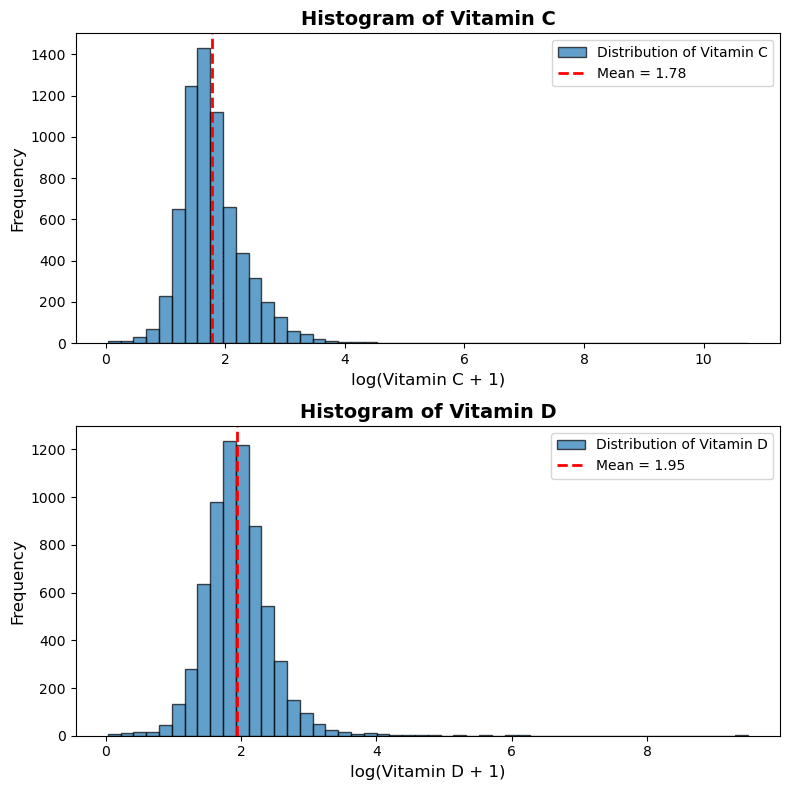

In [46]:
plot_nutrient_histograms(nutrient_ratio, ['Vitamin C', 'Vitamin D'])

In [47]:
print(nutrient_ratio['Vitamin E'].describe())

count    6692.000000
mean        2.778606
std        63.826337
min         0.019050
25%         1.131265
50%         1.576772
75%         2.230004
max      5215.829030
Name: Vitamin E, dtype: float64
